In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [45]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)

  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [46]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [47]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [48]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.num_pulls_per_arm[arm_id] +=1
    self.Q[arm_id] = self.Q[arm_id] + (1/ self.num_pulls_per_arm[arm_id])*(arm_reward - self.Q[arm_id])


  def select_arm(self) -> int:
    # your code for selecting arm based on epsilon greedy policy
    maxQ_id = max(self.Q, key=self.Q.get) # Arm I'd which has the maximum Q value
    Arm_maxQ_prob = 1 - self.epsilon + (self.epsilon / len(self.arm_ids))
    if np.random.rand() < Arm_maxQ_prob:
      return maxQ_id
    else:
      return np.random.choice(self.arm_ids)


In [49]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    self.num_pulls_per_arm[arm_id] +=1
    self.Q[arm_id] = self.Q[arm_id] + (1/ self.num_pulls_per_arm[arm_id])*(arm_reward - self.Q[arm_id])


  def select_arm(self) -> int:
    # your code for selecting arm based on softmax policy
    Qvalues = np.array(list(self.Q.values()))
    Qmax = np.max(Qvalues)
    Qvalues = Qvalues - Qmax # To prevent overflow of values(e^(large value)) which would result in 'NaN' when computed probabilities
    expQ_arms = np.exp(Qvalues / self.tau)
    Prob_arms = expQ_arms / np.sum(expQ_arms)
    return np.random.choice(self.arm_ids, p=Prob_arms) # Select the arms based on the probabilities


In [50]:
class UCB(BasePolicy):
  # your code here
  def __init__(self, c, arm_ids):
    self.c = c # Parameter which controls the degree of exploration
    self.arm_ids = arm_ids
    self.Q = {id:0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id:0 for id in self.arm_ids}
    self.t = 0 # Total number of time the arms have been played
    self.Q_with_Uncertainity = {id:100 for id in self.arm_ids}

  @property
  def name(self):
    return f'UCB c:{self.c}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
    self.t = 0
    self.Q_with_Uncertainity = {id:100 for id in self.arm_ids}


  def update_arm(self, arm_id: int, arm_reward: float):
    self.num_pulls_per_arm[arm_id] +=1 # Increase the count for the Arm selected
    self.t +=1 # Increase the overall count of selecting arms
    self.Q[arm_id] = self.Q[arm_id] + (1/ self.num_pulls_per_arm[arm_id])*(arm_reward - self.Q[arm_id])

    if (self.t < len(self.arm_ids)):
      self.Q_with_Uncertainity[arm_id] = 0 # setting it to zero so that other arms get the chance

    if(self.t >= len(self.arm_ids)): # After pulling each arm once, computing the (Q value + Uncertainity) estimates for all the arms, when a arm is pulled.
      for arm in self.arm_ids:
        uncertainty = np.sqrt(np.log(self.t)/ self.num_pulls_per_arm[arm]) # Uncertainity/ variance in  estimate of Q value
        self.Q_with_Uncertainity[arm] = (self.Q[arm] + self.c * uncertainty)

    return None

  def select_arm(self):

    arm_max_id = max(self.Q_with_Uncertainity, key=self.Q_with_Uncertainity.get) # Arm I'd which has the maximum estmiate of (Q value + Uncertainity)

    return arm_max_id

#### Trainer

In [51]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = np.mean(policy_reward_each_run, axis=0) # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = 0  # your code here (type: float)
  for i in range(timesteps):
    total_policy_regret += (expected_max_reward - avg_policy_rewards[i])

  return avg_policy_rewards, total_policy_regret

In [52]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)

  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')

  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

## Using the 'plot_reward_curve_and_print_regret' function and modifying it to display the reward curves of each exploration degree as a seperate subplot inorder to differentiate better between the curves  

In [53]:
def plot_reward_curves_and_print_regret_UCB(env, policies, timesteps=200, num_runs=500):
    num_policies = len(policies)
    fig, axes = plt.subplots(1, num_policies, figsize=(6.5 * num_policies, 6), sharey=True)

    if num_policies == 1:
        axes = [axes]

    for ax, policy in zip(axes, policies):
        avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
        print(f'Regret for {policy.name}: {total_policy_regret:.3f}')

        ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=f'Policy: {policy.name}')

        expected_max_reward = env.get_best_arm_and_expected_reward()[1]
        ax.plot(np.arange(timesteps), [expected_max_reward] * timesteps, 'g-', label="Best Arm Reward")

        avg_arm_reward = env.get_avg_arm_reward()
        ax.plot(np.arange(timesteps), [avg_arm_reward] * timesteps, 'r-', label="Average Arm Reward")

        ax.legend(loc='lower right', fontsize=8)
        ax.set_title(f"Reward Curve for {policy.name}")
        ax.set_xlabel("Timesteps")

    axes[0].set_ylabel("Average Reward")  # Only leftmost plot will have the y-axis label
    plt.tight_layout()
    plt.show()


### Experiments

In [54]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

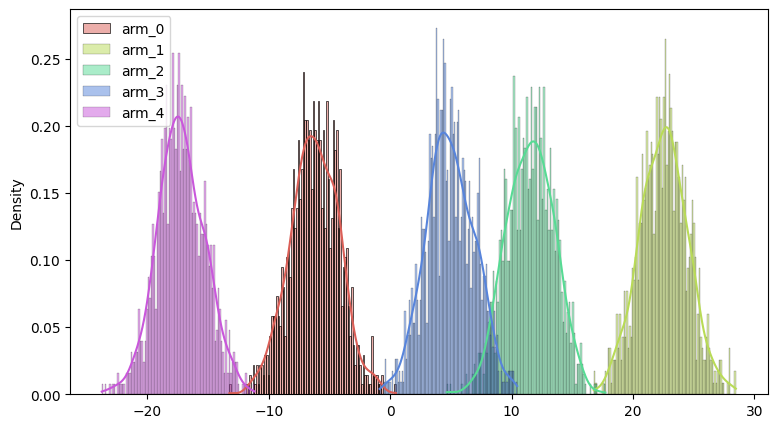

In [55]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [56]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [57]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


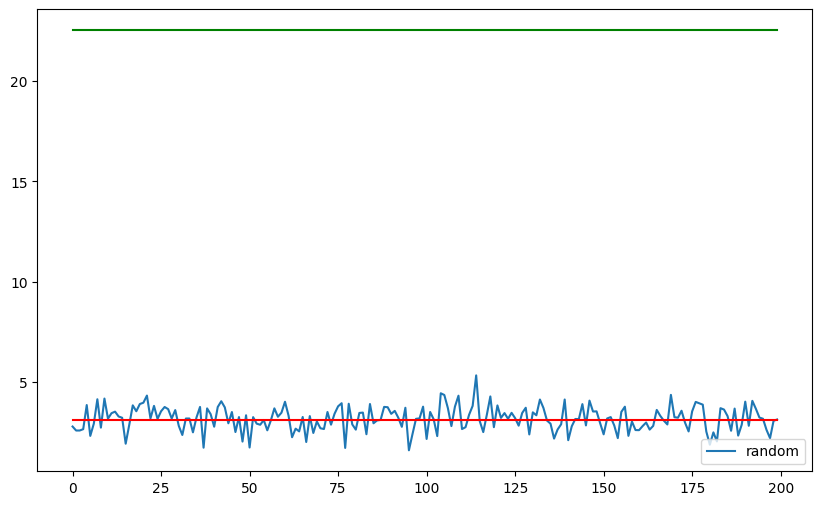

In [58]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 33.216
regret for ep-greedy ep:0.01: 61.133
regret for ep-greedy ep:0.5: 1589.461
regret for ep-greedy ep:0.9: 2812.689


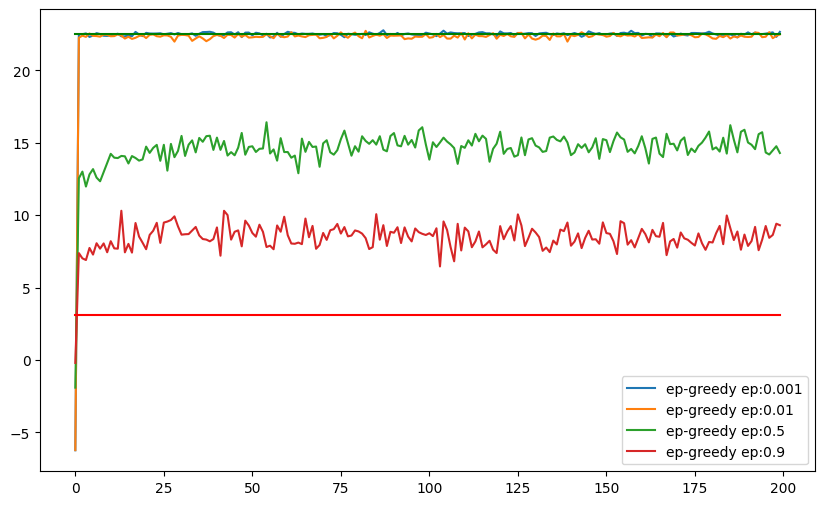

In [59]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1975.059
regret for softmax tau:1.0: 1275.179
regret for softmax tau:5.0: 426.801
regret for softmax tau:50.0: 3165.840


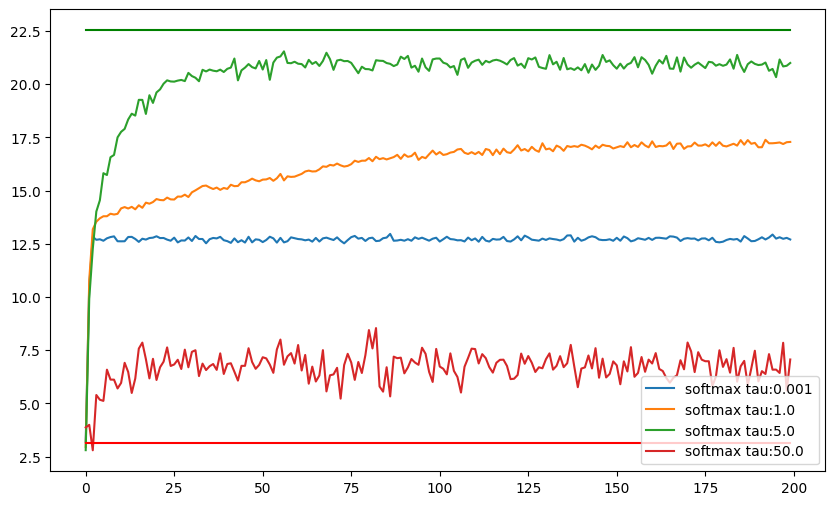

In [60]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB c:1: 97.789
regret for UCB c:10: 143.518
regret for UCB c:20: 360.007
regret for UCB c:25: 471.823


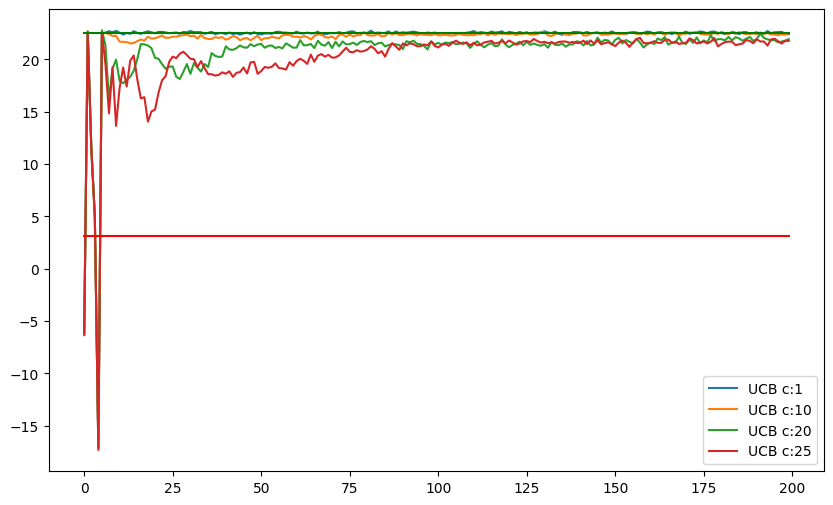

In [61]:
exploration_UCB = [1, 10, 20, 25] # Degree of exploration
ucb_polices = [UCB(c, env.arm_ids) for c in exploration_UCB]
plot_reward_curve_and_print_regret(env, ucb_polices, timesteps=200, num_runs=500)

Regret for UCB c:1: 96.033
Regret for UCB c:10: 144.022
Regret for UCB c:20: 360.848
Regret for UCB c:25: 469.567


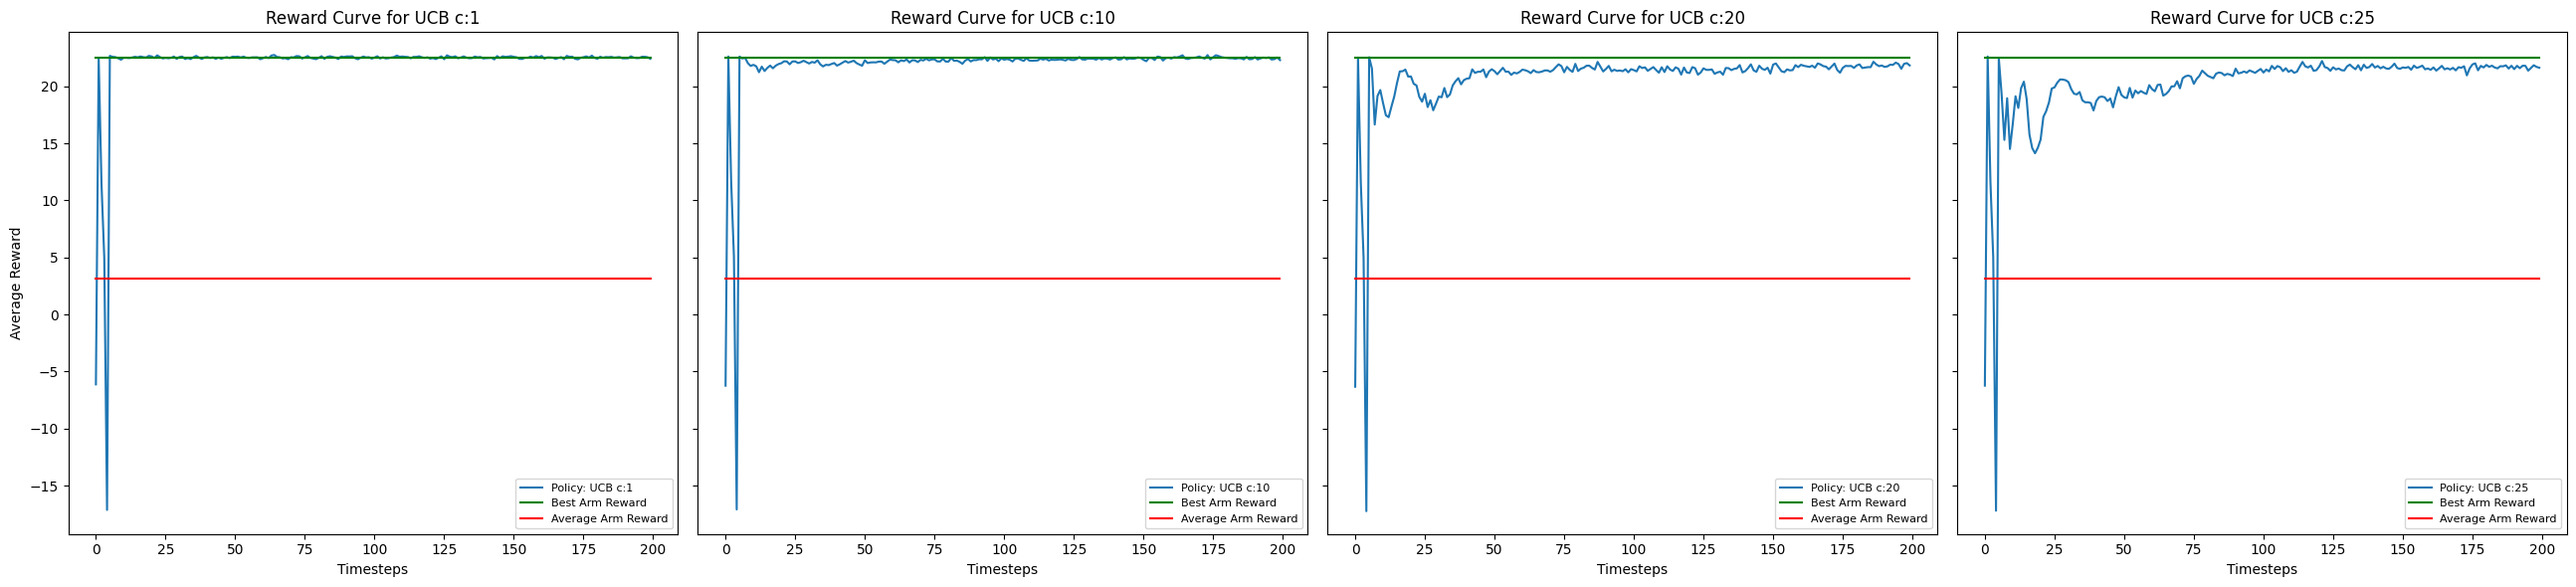

In [62]:
# To display the reward curves of each exploration degree as a seperate subplot inorder to differentiate better between the curves
plot_reward_curves_and_print_regret_UCB(env, ucb_polices, timesteps=200, num_runs=500)

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.

regret for ep-greedy ep:0.0001: 30.519
regret for ep-greedy ep:0.05: 202.015
regret for ep-greedy ep:0.1: 399.451
regret for ep-greedy ep:0.9: 2818.007


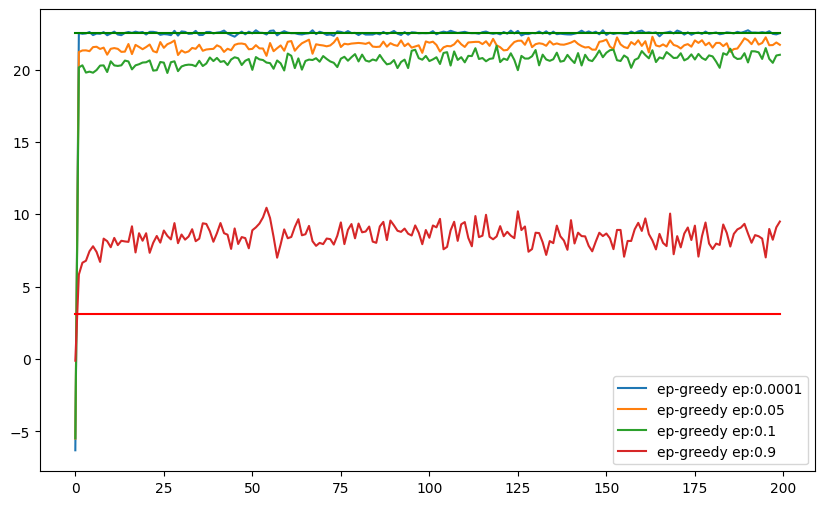

In [63]:
# Exploring diff values of epsilon: Epsilon Greedy policy
explore_epgreedy_epsilons =  [1e-4, 5e-2, 0.1, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

From the plots it is evident that as the value of epsilon is low, the algorithm exploits the best arm(arm with highest estimated expected reward) with a very high probabilty of ((1 - ϵ) + (ϵ/ n), n - total number of arms) and explores the other arms with low probability.

As the value of epsilon increases the algorithm explores the other arms along with exploiting the best arm, but the probability of choosing the best arm 'reduces' as ϵ increases and the probability of exploring the other arms tends to be higher when compared to ϵ being low. This results in a drop in the average rewards obtained by the algorithm over time steps as it fails to exploit the best arm in order to maximize the expected rewards causing a significant increase of regret. For example: Reward curve of ϵ = 0.9

regret for softmax tau:1e-06: 1807.965
regret for softmax tau:0.01: 1862.240
regret for softmax tau:100.0: 3525.358
regret for softmax tau:1000000.0: 3874.780


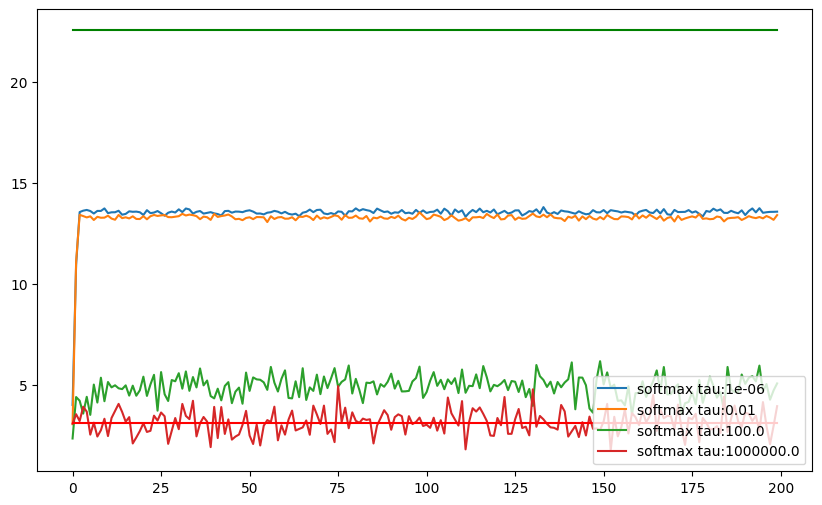

In [64]:
# Exploring diff values of tau: SoftMax Policy
explore_softmax_taus =  [1e-6, 1e-2, 1e2, 1e6]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

From the plot its is evident that as the value of tau is very low, small changes in the Q values of the arms would lead to large differences in the probabilty values there by the softmax policy behaves as a greedy policy with minimal exploration and often tends to exploit the arm which provides suboptimal performance.

As the value of tau is large compared to the True means/ Estimated expected rewards of the arms, the probability of the arms tends to be uniform in nature and the softmax policy keeps exploring the arms. It fails to exploit the arm with highest estimated expected reward leading to huge variations in the average rewards and poor performance.

## Generate PDF

In [66]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Colab Notebooks/DA6400_Bandits_DA24S018.ipynb
# Replace 'your_notebook_name.ipynb' with the actual name of your notebook file.